# 1. Analisi Esplorativa dei Dati (EDA) - Classificazione Rifiuti

In questo notebook, esploreremo il dataset "Garbage Classification" per comprendere le sue caratteristiche principali prima di procedere con la costruzione del modello.

---

## Obiettivi
- Caricare e ispezionare il dataset.
- Analizzare la distribuzione delle classi per verificare il bilanciamento.
- Visualizzare esempi di immagini per ogni categoria.
- Riassumere le scoperte e definire i prossimi passi.

## 1. Setup dell'Ambiente

### 1.1 Import delle Librerie
In questa sezione importiamo tutte le librerie necessarie per l'analisi.

In [1]:
# --- Librerie Standard e di Sistema ---
import os
import pathlib
import random

# --- Librerie per l'Analisi e Manipolazione Dati ---
import pandas as pd
import numpy as np

# --- Librerie per la Visualizzazione ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Framework di Deep Learning (per utility e ispezione) ---
import tensorflow as tf
from tensorflow.keras.utils import load_img

# --- Librerie per la Manipolazione delle Immagini ---
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.manifold import TSNE
import time

# Impostazioni per una migliore visualizzazione
%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate correttamente!")
print(f"Versione di TensorFlow: {tf.__version__}")

Librerie importate correttamente!
Versione di TensorFlow: 2.19.0


### 1.2 Definizione dei Percorsi e delle Costanti
Definiamo qui le variabili globali, come il percorso alla cartella dei dati, per rendere il codice più pulito e manutenibile.

In [2]:
DATA_DIR = pathlib.Path('../data/raw/Garbage classification')

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32

if DATA_DIR.exists():
    print(f"Cartella dati trovata in: {DATA_DIR}")
else:
    print(f"ATTENZIONE: La cartella dati non è stata trovata in: {DATA_DIR}")
    print("Assicurati di aver scaricato e scompattato i dati correttamente.")

Cartella dati trovata in: ../data/raw/Garbage classification


## 2 Analisi delle Classi e Conteggio delle Immagini
Scansioniamo le directory per identificare le classi (sottocartelle) e contare il numero di immagini in ciascuna di esse. I risultati verranno raccolti in un DataFrame Pandas per una facile manipolazione.

In [3]:
image_data = []

# Scansiona le sottocartelle per contare le immagini
for item in DATA_DIR.iterdir():
    if item.is_dir():
        class_name = item.name
        # Conta tutte le immagini comuni (.jpg, .jpeg, .png)
        num_images = len(list(item.glob('*.[jJ][pP]*[gG]'))) + len(list(item.glob('*.[pP][nN][gG]')))
        image_data.append({'class_name': class_name, 'image_count': num_images})

# Crea e ordina il DataFrame
df = pd.DataFrame(image_data).sort_values(by='class_name').reset_index(drop=True)
# Rimuove la cartella .DS_Store se presente
df = df[df.class_name != '.DS_Store']

# Mostra i risultati
print(f"Trovate {len(df)} classi e {df['image_count'].sum()} immagini totali.")
df

Trovate 6 classi e 2527 immagini totali.


,class_name,image_count
0,cardboard,403
1,glass,501
2,metal,410
3,paper,594
4,plastic,482
5,trash,137


## 3. Analisi della Distribuzione delle Classi

Creiamo un grafico a barre per visualizzare il numero di campioni per ogni classe. Questo è un passo fondamentale per capire se il dataset è bilanciato o se sarà necessario applicare tecniche di ricampionamento.

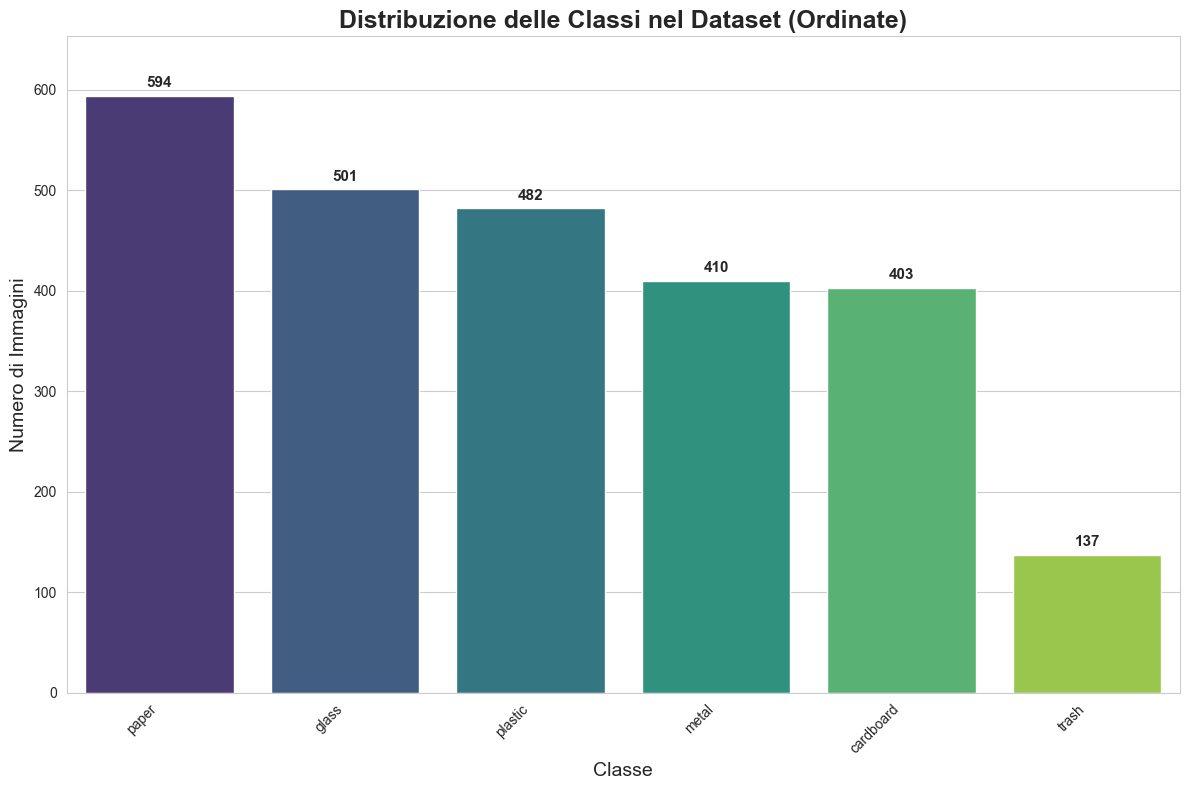

In [4]:
# Ordina il DataFrame per rendere il grafico più leggibile
df_sorted = df.sort_values('image_count', ascending=False)

# Imposta le dimensioni del grafico
plt.figure(figsize=(12, 8))

# Crea il grafico a barre con una palette di colori e salvalo in una variabile 'ax'
palette = sns.color_palette("viridis", len(df_sorted))
ax = sns.barplot(x='class_name', y='image_count', data=df_sorted, palette=palette, legend=False, hue='class_name')

# Aggiungi le etichette con il conteggio esatto sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=11,
                weight='bold')

# Aggiunge un titolo e le etichette
plt.title('Distribuzione delle Classi nel Dataset (Ordinate)', fontsize=18, weight='bold')
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Numero di Immagini', fontsize=14)
plt.xticks(rotation=45, ha='right') # Ruota le etichette per una migliore visuale
plt.ylim(0, df_sorted['image_count'].max() * 1.1) # Aumenta lo spazio in alto

# Migliora il layout
plt.tight_layout()

# Mostra il grafico
plt.show()

## 4. Visualizzazione delle Immagini

Mostriamo una griglia di immagini casuali per ogni classe per avere un'idea qualitativa dei dati. Osserviamo la variabilità, la qualità delle immagini, lo sfondo e altri dettagli utili.

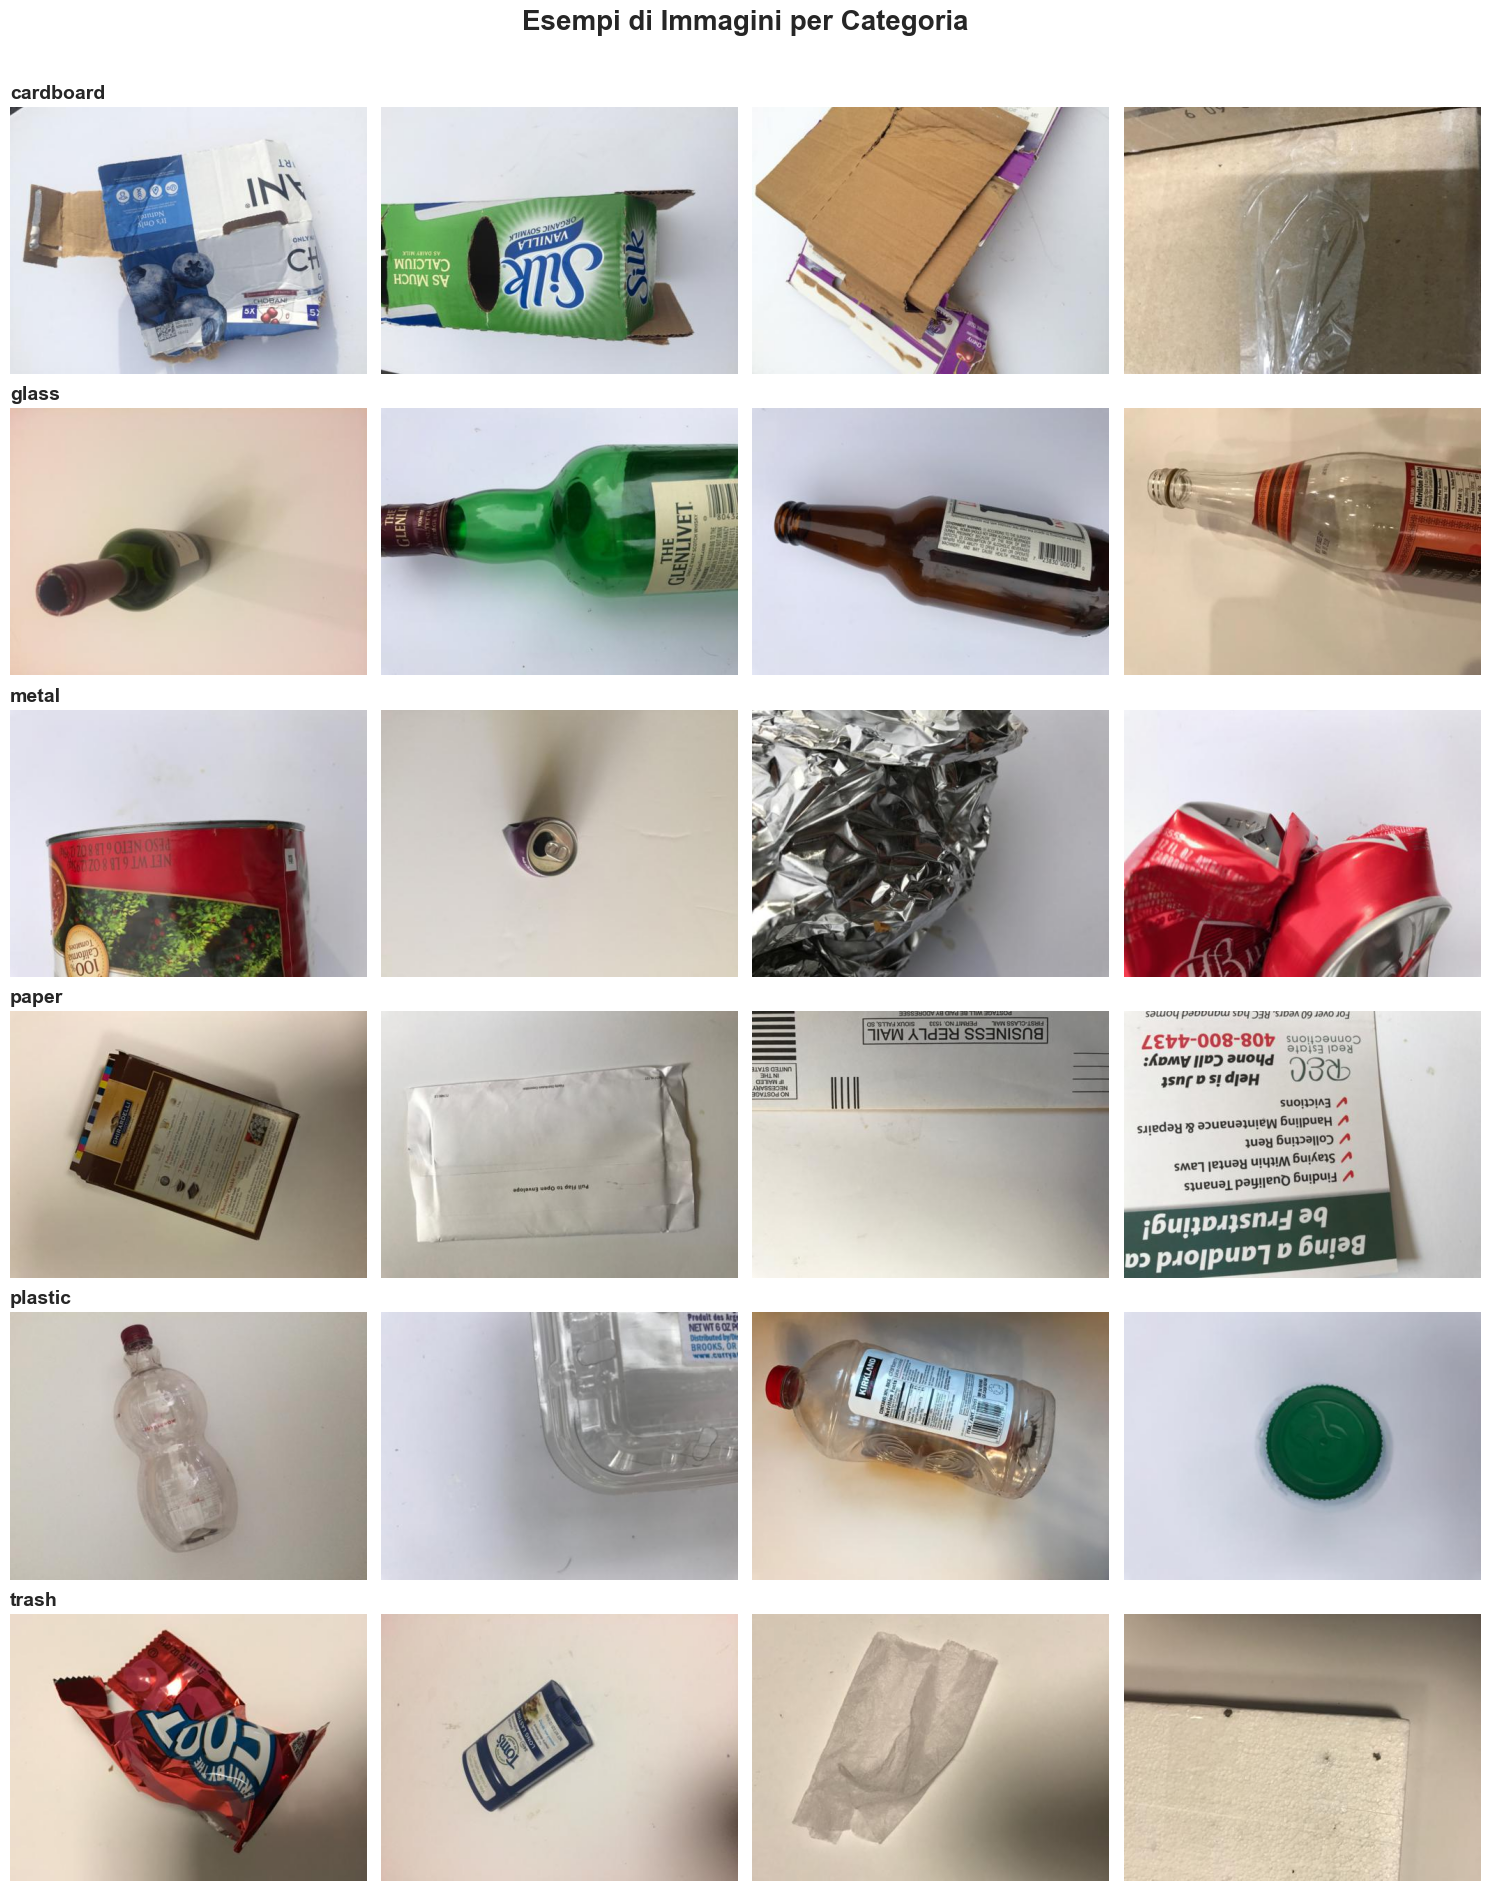

In [5]:
# Ottiene la lista delle classi dal nostro DataFrame
class_names = df['class_name'].tolist()

# Imposta le dimensioni della griglia (una riga per classe, 4 colonne per esempi)
num_rows = len(class_names)
num_cols = 4

# Crea la figura e gli assi per la griglia
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

# Imposta un titolo principale per l'intera griglia
fig.suptitle('Esempi di Immagini per Categoria', fontsize=20, weight='bold')

for i, class_name in enumerate(class_names):
    # Ottiene il percorso della cartella per la classe corrente
    class_dir = DATA_DIR / class_name
    
    # Prende una lista di tutti i percorsi delle immagini in quella cartella
    image_paths = list(class_dir.glob('*.[jJ][pP]*[gG]')) + list(class_dir.glob('*.[pP][nN][gG]'))
    
    # Seleziona 4 immagini a caso
    random_images = random.sample(image_paths, num_cols)
    
    # Mostra le immagini sulla riga corrispondente della griglia
    for j, img_path in enumerate(random_images):
        # Carica l'immagine
        img = load_img(img_path)
        
        # Usa l'asse corretto per plottare
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off') # Nasconde gli assi numerici
        
        # Aggiunge il nome della classe solo sulla prima immagine di ogni riga
        if j == 0:
            ax.set_title(class_name, fontsize=14, weight='bold', loc='left')

# Ottimizza la spaziatura e mostra il grafico
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Aggiusta per far spazio al super-titolo
plt.show()

## 5. Analisi di Separabilità con t-SNE 

Questa è l'analisi più avanzata della nostra EDA. L'obiettivo è visualizzare quanto le nostre classi sono "separabili" dal punto di vista di una rete neurale.

Per fare ciò, utilizziamo un modello pre-addestrato (**MobileNetV2**) per estrarre un vettore di features (un *embedding*) da ogni immagine. Successivamente, usiamo l'algoritmo **t-SNE** per proiettare questi vettori ad alta dimensionalità in uno spazio 2D.

Se le classi formano cluster ben distinti, il problema di classificazione sarà più semplice. Se i cluster si sovrappongono, ci aspettiamo che il modello faccia più fatica a distinguere quelle classi.

Inizio estrazione delle features (può richiedere qualche minuto)...
Estrazione completata in 41.55 secondi.

Applicazione di t-SNE...


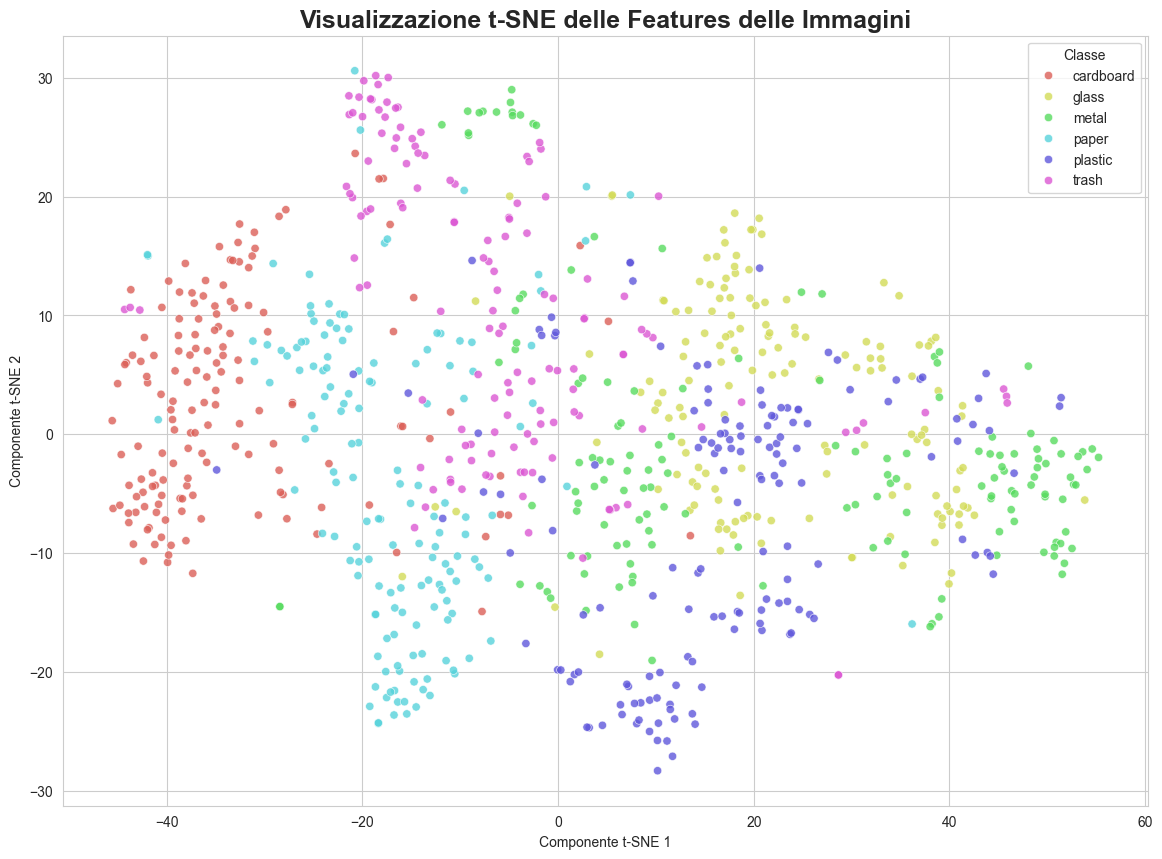

In [6]:
# Carica il modello MobileNetV2 pre-addestrato senza il classificatore finale
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

def extract_features(img_path):
    # Carica l'immagine e la ridimensiona a 224x224
    img = load_img(img_path, target_size=(224, 224))
    # Converte l'immagine in un array e la pre-processa per MobileNetV2
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # Estrae le features
    features = base_model.predict(x, verbose=0)
    return features.flatten()

# Estraiamo le features da un campione di immagini per velocizzare
# (es. 150 immagini per classe)
features_list = []
labels_list = []
sample_size = 150

print("Inizio estrazione delle features (può richiedere qualche minuto)...")
start_time = time.time()

for class_name in df['class_name'].tolist():
    class_dir = DATA_DIR / class_name
    image_paths = list(class_dir.glob('*.[jJ][pP]*[gG]'))
    # Prende un campione casuale di immagini
    sampled_paths = random.sample(image_paths, min(sample_size, len(image_paths)))
    
    for img_path in sampled_paths:
        features_list.append(extract_features(img_path))
        labels_list.append(class_name)

end_time = time.time()
print(f"Estrazione completata in {end_time - start_time:.2f} secondi.")

# Applica t-SNE
print("\nApplicazione di t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(np.array(features_list))

# Crea un DataFrame per la visualizzazione
tsne_df = pd.DataFrame(data=tsne_features, columns=['x', 'y'])
tsne_df['label'] = labels_list

# Visualizza il risultato
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette=sns.color_palette("hls", len(class_names)),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('Visualizzazione t-SNE delle Features delle Immagini', fontsize=18, weight='bold')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(title='Classe')
plt.show()

## 6. Conclusioni e Prossimi Passi

Questa analisi esplorativa approfondita ci ha fornito una comprensione completa del nostro dataset. Riassumiamo le scoperte finali:

1.  **Dataset e Sbilanciamento**: Abbiamo a disposizione 2527 immagini divise in 6 classi. Il dataset è moderatamente sbilanciato, con la classe `trash` che è la meno rappresentata.

2.  **Consistenza delle Immagini**: L'analisi ha rivelato un grande vantaggio: **tutte le immagini hanno una dimensione standard di 512x384 pixel**. Questo semplificherà notevolmente la fase di pre-processing, eliminando la necessità di gestire proporzioni diverse.

3.  **Separabilità delle Classi (t-SNE)**: La visualizzazione t-SNE ha mostrato che **le classi possiedono una struttura latente che un modello può apprendere**. Cluster come `cardboard` sono relativamente ben definiti, mentre altri (es. `plastic`, `glass`, `trash`) mostrano una significativa sovrapposizione. Questo ci dà un'anteprima realistica delle performance che possiamo aspettarci: il modello imparerà, ma probabilmente confonderà le classi visivamente più simili.

4.  **Sfida Principale**: La sfida non sarà la qualità delle immagini, ma la **variabilità di angolazione e deformazione** degli oggetti e la **somiglianza intrinseca** tra alcune categorie, come confermato dalla sovrapposizione dei cluster nel grafico t-SNE.

---
### **Prossimi Passi**

L'analisi esplorativa è conclusa. Nel prossimo notebook, **`Simple_CNN.ipynb`**, useremo queste conoscenze per:

1.  **Preparare i Dati**: Suddividere il dataset in training e validation set.

2.  **Costruire un Modello Base**: Implementare una CNN semplice da zero per stabilire una **baseline di performance**.

3.  **Addestrare e Valutare**: Misurare quanto bene un modello semplice riesce a risolvere questo problema di classificazione, prima di passare a tecniche più avanzate.